In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
full_df = pd.read_csv('/content/drive/segemented_Data_rfm.csv')

In [ ]:
full_df.columns

Index(['customer_id', 'Recency', 'Frequency', 'Monetary', 'order_id',
       'order_purchase_timestamp', 'product_id', 'price', 'customer_city',
       'customer_state', 'product_category_name', 'Margin', 'Profit',
       'Cluster', 'Cluster_Name'],
      dtype='object')

In [ ]:
cluster_summary = full_df.groupby("Cluster_Name").agg({"Recency": "mean", "Frequency": "mean", "Monetary": "mean", "Cluster":"count","Profit":"mean","price":"mean"})
cluster_summary = cluster_summary.rename(columns={"Cluster":"Count"})
cluster_summary

,Recency,Frequency,Monetary,Count,Profit,price
Cluster_Name,,,,,,
Dormant,396.241741,1.381959,223.594408,48068,37.047785,120.547529
Medium spenders,345.781915,31.388298,892.494574,376,-71.081250,107.923511
Occasional Buyers,134.947771,1.321936,215.771094,64926,37.737562,119.742334
Potential VIP,235.606294,6.818881,3077.488013,4163,392.445626,136.033685
VIP,254.294118,14.941176,48496.685882,68,3838.719118,490.566176


# Saving Segement-wise Percentile Summary

In [ ]:
def percentile_summary(df, group_col, cols):
  summary_dict = {}
  for cluster_name in df[group_col].unique():
      cluster_data = df[df[group_col] == cluster_name]
      percentiles = cluster_data[cols].describe(percentiles=[0.25, 0.5, 0.75, 0.9])
      summary_dict[cluster_name] = percentiles
  return summary_dict

# Example usage: Assuming 'full_df' is already defined
cols_to_summarize = ['Recency', 'Frequency', 'Monetary', 'price', 'Profit','Margin'] #'Margin' column might not exist
percentile_summaries = percentile_summary(full_df, "Cluster_Name", cols_to_summarize)


# Save summaries to Excel file
with pd.ExcelWriter('/content/drive/percentile_summaries.xlsx') as writer:
    for cluster_name, summary_df in percentile_summaries.items():
        summary_df.to_excel(writer, sheet_name=cluster_name)


In [ ]:
# Create distinct dfs for each segment for analysis

Dormant_df = full_df[full_df['Cluster_Name'] == 'Dormant']
Occasional_Buyers_df = full_df[full_df['Cluster_Name'] == 'Occasional Buyers']
Potential_VIP_df = full_df[full_df['Cluster_Name'] == 'Potential VIP']
VIP_df = full_df[full_df['Cluster_Name'] == 'VIP']
Medium_spenders_df = full_df[full_df['Cluster_Name'] == 'Medium Spenders']

In [ ]:
# Aggregate category purchases per cluster
category_cluster_data = full_df.groupby(['Cluster_Name', 'product_category_name'])['order_id'].count().reset_index()

# Pivot for visualization
category_cluster_pivot = category_cluster_data.pivot(index='product_category_name', columns='Cluster_Name', values='order_id').fillna(0)

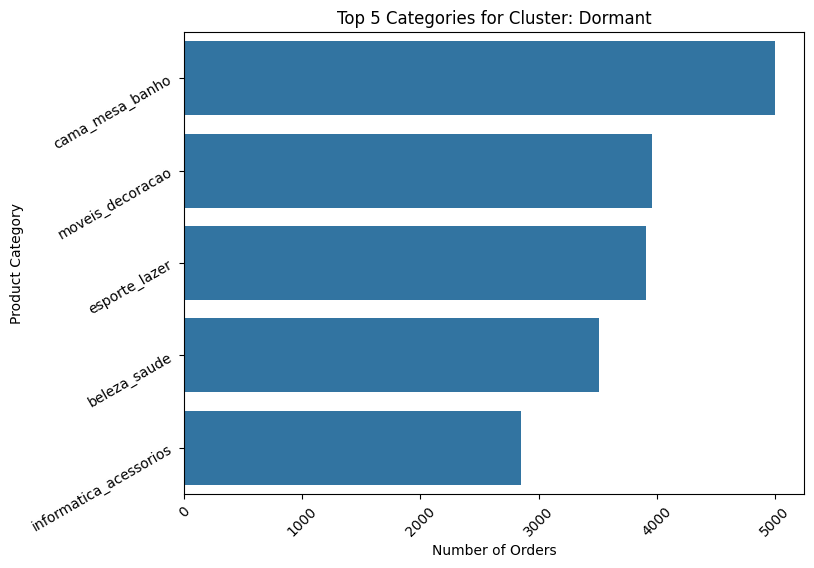

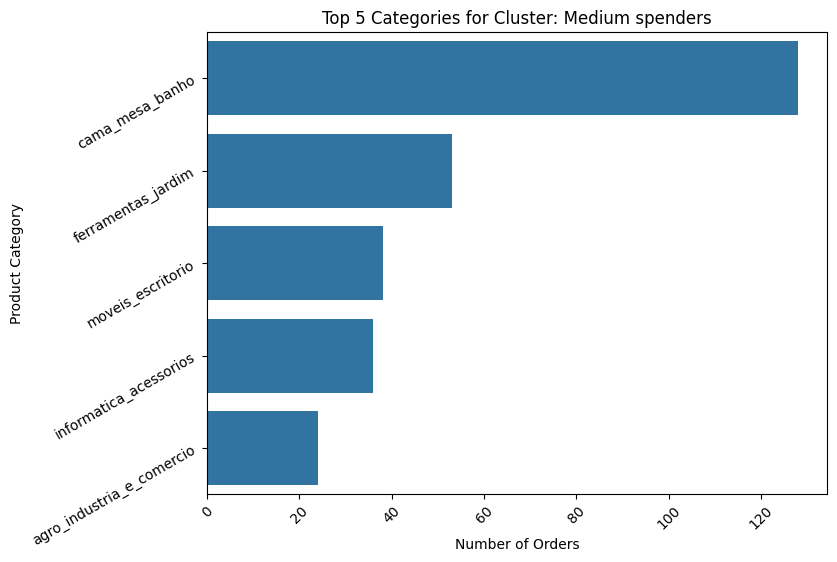

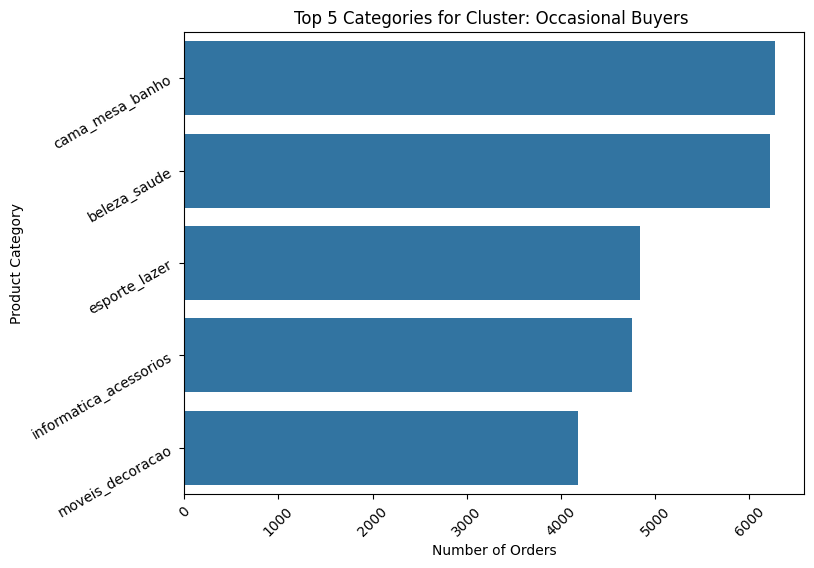

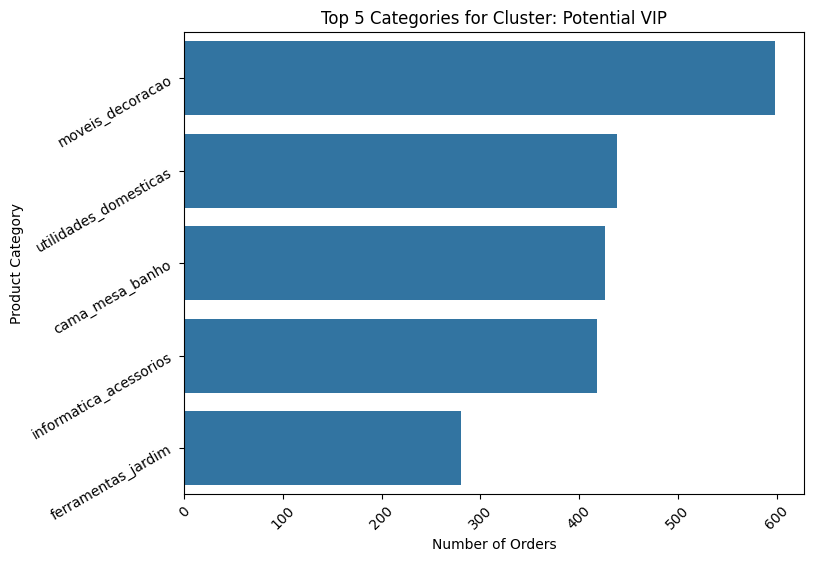

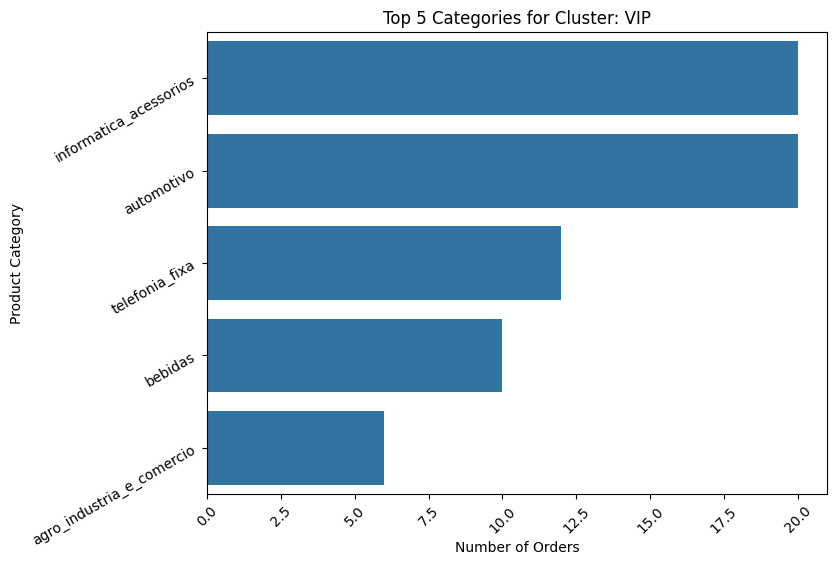

In [ ]:
# Top 5 categories by Order Volume for each Segment

def plot_top_categories(cluster_name, top_n=5):
    cluster_data = category_cluster_pivot[cluster_name].sort_values(ascending=False).head(top_n)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=cluster_data.values, y=cluster_data.index)
    plt.title(f"Top {top_n} Categories for Cluster: {cluster_name}")
    plt.xlabel("Number of Orders")
    plt.ylabel("Product Category")
    plt.xticks(rotation=45)
    plt.yticks(rotation=30)
    plt.show()

# Plotting for each Segment
for cluster in category_cluster_pivot.columns:
    plot_top_categories(cluster)


In [ ]:
# Top 5 categories by Order Volume for each Segment

def top_categories_by_volume(cluster_name, top_n=10):
    # Calculate mean margin for each category within the cluster
    cluster_volume = full_df[full_df['Cluster_Name'] == cluster_name].groupby('product_category_name')['Cluster_Name'].count().sort_values(ascending=False).head(top_n)
    return cluster_volume

# Print top categories for each cluster
for cluster in category_cluster_pivot.columns:
  print(f"Top {10} categories by Volume for cluster {cluster}:")
  print(top_categories_by_volume(cluster))
  print("\n")


Top 10 categories by Volume for cluster Dormant:
product_category_name
cama_mesa_banho           4999
moveis_decoracao          3960
esporte_lazer             3907
beleza_saude              3510
informatica_acessorios    2853
utilidades_domesticas     2764
brinquedos                2483
cool_stuff                2255
ferramentas_jardim        2243
telefonia                 2106
Name: Cluster_Name, dtype: int64


Top 10 categories by Volume for cluster Medium spenders:
product_category_name
cama_mesa_banho              128
ferramentas_jardim            53
moveis_escritorio             38
informatica_acessorios        36
agro_industria_e_comercio     24
eletronicos                   22
beleza_saude                  21
esporte_lazer                 21
utilidades_domesticas         21
malas_acessorios              12
Name: Cluster_Name, dtype: int64


Top 10 categories by Volume for cluster Occasional Buyers :
product_category_name
cama_mesa_banho           6270
beleza_saude              6

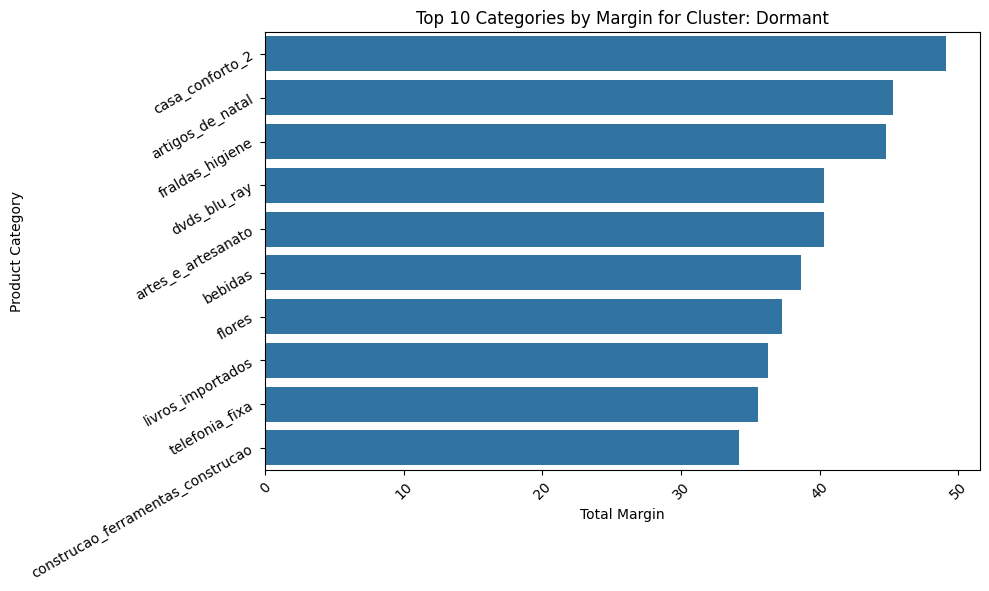

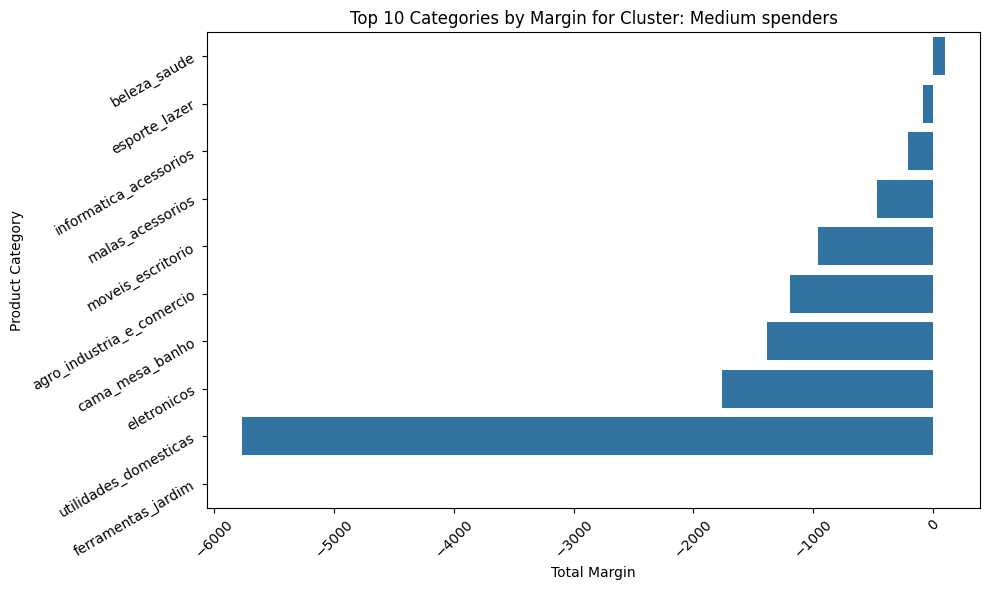

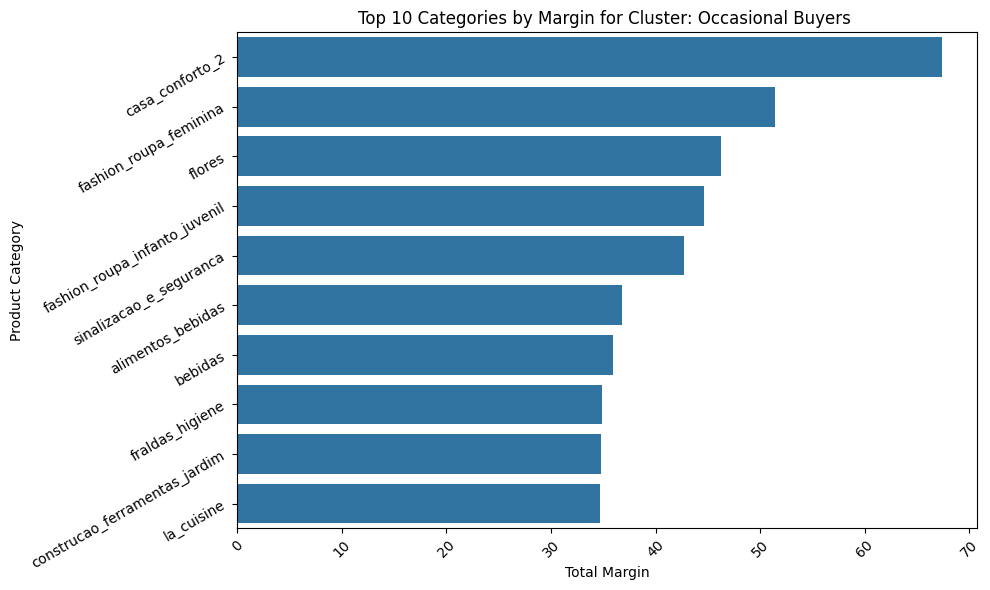

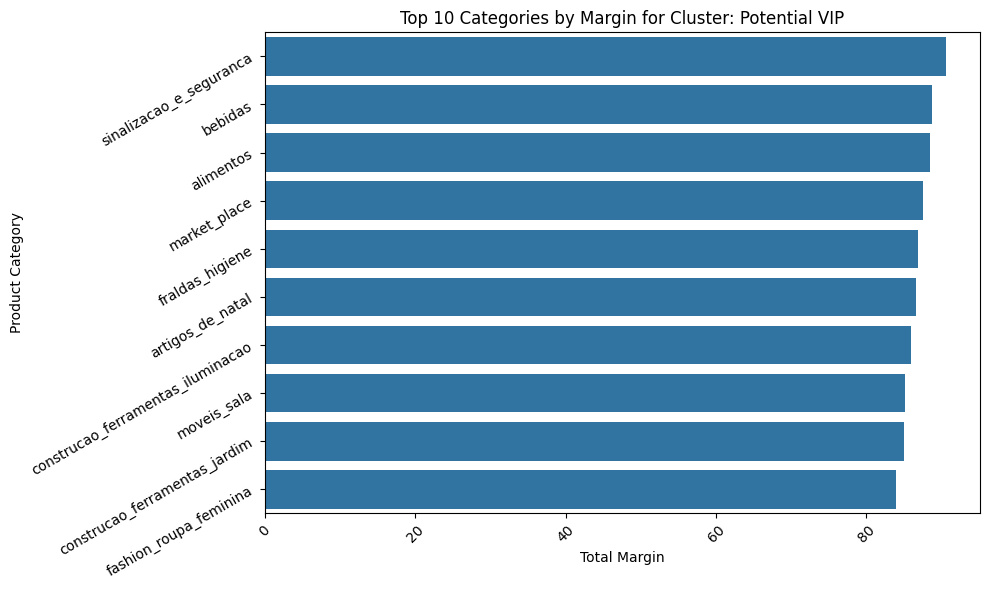

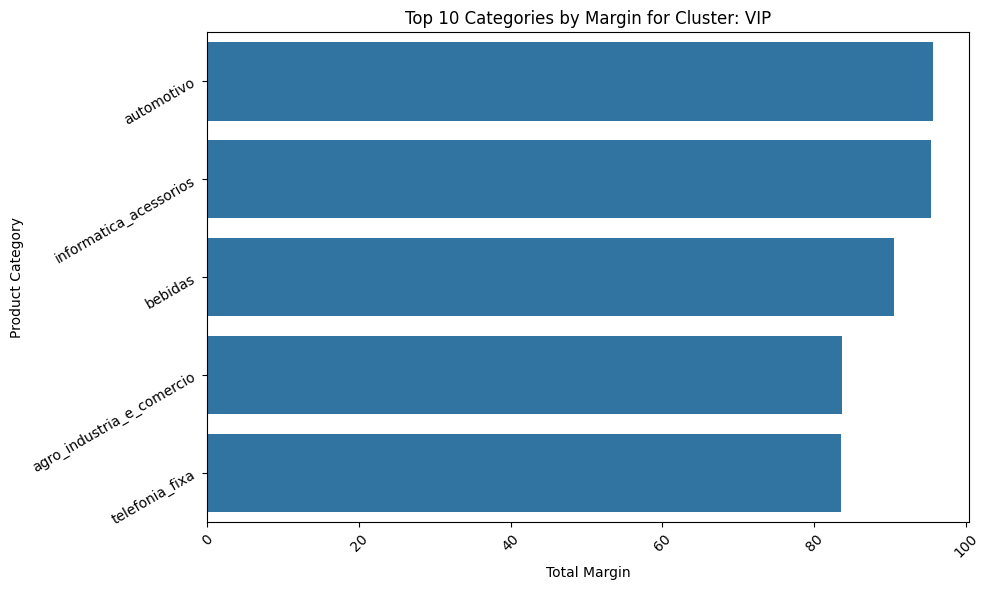

In [ ]:
# Top 5 categories by Margin for each Segment

def plot_top_categories_with_margin(cluster_name, top_n=10):
    # Calculate margin for each category within the cluster
    cluster_margin = full_df[full_df['Cluster_Name'] == cluster_name].groupby('product_category_name')['Margin'].mean()

    # Get the top N categories based on margin
    top_categories = cluster_margin.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_categories.values, y=top_categories.index)
    plt.title(f"Top {top_n} Categories by Margin for Cluster: {cluster_name}")
    plt.xlabel("Total Margin")
    plt.ylabel("Product Category")
    plt.xticks(rotation=45)
    plt.yticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Plotting for each cluster
for cluster in category_cluster_pivot.columns:
    plot_top_categories_with_margin(cluster)


In [ ]:
# Top 5 categories by Margin for each Segment

def top_categories_by_margin(cluster_name, top_n=10):
    # Calculate mean margin for each category within the cluster
    cluster_margin = full_df[full_df['Cluster_Name'] == cluster_name].groupby('product_category_name')['Margin'].mean().sort_values(ascending=False).head(top_n)
    return cluster_margin

# Print top categories for each cluster
for cluster in category_cluster_pivot.columns:
  print(f"Top {10} categories by mean margin for cluster {cluster}:")
  print(top_categories_by_margin(cluster))
  print("\n")


Top 10 categories by mean margin for cluster Dormant:
product_category_name
casa_conforto_2                      49.119975
artigos_de_natal                     45.263753
fraldas_higiene                      44.809216
dvds_blu_ray                         40.352559
artes_e_artesanato                   40.332010
bebidas                              38.632030
flores                               37.289993
livros_importados                    36.259141
telefonia_fixa                       35.543221
construcao_ferramentas_construcao    34.195601
Name: Margin, dtype: float64


Top 10 categories by mean margin for cluster Medium spenders:
product_category_name
beleza_saude                   99.227839
esporte_lazer                 -83.668707
informatica_acessorios       -204.801466
malas_acessorios             -469.410956
moveis_escritorio            -963.055501
agro_industria_e_comercio   -1189.872340
cama_mesa_banho             -1387.395840
eletronicos                 -1761.190818
utilidades_